In [1]:
import numpy as np
import ase
import glob
from matplotlib import pyplot as plt

import pandas as pd
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm
from parse_density_files import CUBE
import alchemy_tools2 as at
from ase.units import Bohr


In [2]:
def load_cubes(paths):
    cubes = dict()
    for p in paths:
        cube = CUBE(p)
        name = p.split('/')[-2]
        cubes[name] = cube
    return(cubes)
def check_cube(cubes, num_ve):
    for k in cubes.keys():
        if not np.isclose(cubes[k].data_scaled.sum(), num_ve):
            print(f'{k} does not integrate to correct num_ve')

### Load cube files

In [3]:
paths08 = glob.glob('/home/misa/projects/atomic-energies/data/ueg_reference/amons/geometry/bond_stretch/ethane_cc/d_0.8/ve_*/DENSITY.cube')
paths10 = glob.glob('/home/misa/projects/atomic-energies/data/ueg_reference/amons/geometry/bond_stretch/ethane_cc/d_1.0/ve_*/DENSITY.cube')
paths12 = glob.glob('/home/misa/projects/atomic-energies/data/ueg_reference/amons/geometry/bond_stretch/ethane_cc/d_1.2/ve_*/DENSITY.cube')
paths15 = glob.glob('/home/misa/projects/atomic-energies/data/ueg_reference/amons/geometry/bond_stretch/ethane_cc/d_1.5/ve_*/DENSITY.cube')
paths20 = glob.glob('/home/misa/projects/atomic-energies/data/ueg_reference/amons/geometry/bond_stretch/ethane_cc/d_2.0/ve_*/DENSITY.cube')

paths = [paths08, paths10, paths12, paths15, paths20]
dcubes = []
for p in paths:
    p.sort()
    dcubes.append(load_cubes(p))
    
for dc, p in zip(dcubes,paths):
    d = p[0].split('/')[-3]
    print(f'distance = {d}')
    check_cube(dc, 14)

distance = d_0.8
distance = d_1.0
distance = d_1.2
distance = d_1.5
distance = d_2.0


#### uniform electron gas electron density

In [4]:
ueg = np.zeros((126,126,126))
ueg[:] = 14/126**3
print(ueg.sum())

13.999999999999995


#### nuclei, CC-distance, electron density grid and h-matrix

In [5]:
dnuclei = []

for cube in dcubes:
    dnuclei.append(cube['ve_14'].atoms)

hmatrix = dcubes[1]['ve_14'].get_hmatrix()
gpts = dcubes[1]['ve_14'].get_grid()

dist = np.array([0.85, 1.0, 1.2, 1.5, 2.0])

### $\mu(\lambda)$ for all distances

In [6]:
def get_alchpot(cubes, ueg, nuclei, meshgrid, h_matrix, intg_method = 'sum'):
    """
    \mu(\lambda) for one particular C-C distance
    """
    alchpots = []
    
    alchpots.append(at.calculate_atomic_energies(ueg, nuclei, meshgrid, h_matrix, intg_method)[-1])
    for k in cubes:
        alch_pots_k = at.calculate_atomic_energies(cubes[k].data_scaled, nuclei, meshgrid, h_matrix, intg_method='sum')[-1]
        alchpots.append(alch_pots_k)
    alchpots = np.array(alchpots)
    return(alchpots)

def order_alchpots(alchpots_raw):
    """
    assign alchpots to atoms
    """
    alchpots = dict()
    atoms_labels = ['C1', 'C2', 'H11', 'H12', 'H13', 'H21', 'H22', 'H23']
    number_atoms = alchpots_raw.shape[1]
    for i in range(number_atoms):
        alchpots[atoms_labels[i]] = alchpots_raw[:, i]
    return(alchpots)

In [7]:
mu_lambda = dict()
for d, dc, nuc in zip(dist, dcubes, dnuclei):
    alchpots_raw = get_alchpot(dc, ueg, nuc, gpts, hmatrix, 'sum') # alchpts for one C-C distance
    mu_lambda[f'd_{d}'] = order_alchpots(alchpots_raw)

### $\tilde{\mu}$ 

In [8]:
mu_tilde = dict()
lambdas = np.array([0, 3,6,8,11,14])/14
for k in mu_lambda.keys(): # select one C-C distance
    mu_tilde_atom = dict()
    for k2 in mu_lambda[k].keys(): # select specific atom at one C-C distance
        alchpots = mu_lambda[k][k2] # select alchpots
        mu_tilde_atom[k2] = np.trapz(alchpots, lambdas) # integrate over lambda -> mu tilde
    mu_tilde[k] = mu_tilde_atom

### Electronic energy

In [9]:
electronic_energy = dict()
for k in mu_tilde.keys(): # select one C-C distance
    electronic_energy_atoms = dict()
    for k2 in mu_tilde[k].keys(): # select specific atom at one C-C distance
        if 'C' in k2:
            Z = 6
        elif 'H' in k2:
            Z = 1
        else:
            raise 'Unknown element'
        electronic_energy_atoms[k2] = mu_tilde[k][k2]*Z # select mu_tilde
    electronic_energy[k] = electronic_energy_atoms

### Total energy

In [10]:
def get_enn(nuclei):
    E_NN = []
    for n in nuclei:
        enn_n = 0
        for m in nuclei:
            if not np.array_equal(n, m):
                enn_n += m[0]/np.linalg.norm(n[1:4]-m[1:4])
        E_NN.append(n[0]*enn_n/2)
    return(np.array(E_NN))

# nuclear repulsion
E_NN = dict()
for dnuc, k in zip(dnuclei, electronic_energy.keys()):
    E_NN[k] = get_enn(dnuc)

In [11]:
total_energy = dict()
for k in electronic_energy.keys():
    total_energy_atoms = dict()
    for k2, enn in zip(electronic_energy[k].keys(), E_NN[k]):
        total_energy_atoms[k2] = electronic_energy[k][k2] + enn
    total_energy[k] = total_energy_atoms

### shift

In [12]:
shift = lambda e_alch, e_npbc, sum_Z : (e_npbc - e_alch)/sum_Z
energy_shifted = lambda E_I, Z_I, shift : E_I + Z_I*shift

In [13]:
atomic_energies_sum = dict()
for k in total_energy.keys():
    sum_energies = 0
    for k2 in total_energy[k].keys():
        sum_energies += total_energy[k][k2]
    atomic_energies_sum[k] = sum_energies
e_pbe_def2tzvp = [-79.69169971618916, -79.73090080716617, -79.70186898780051,-79.63264205190806, -79.55480003172102]

In [14]:
shifts = dict()

for i, k in enumerate(atomic_energies_sum.keys()):
    Z_sum = dnuclei[i][:,0].sum()
    shifts[k] = shift(atomic_energies_sum[k], e_pbe_def2tzvp[i], Z_sum)

corrected_atomic_energies = dict()
for k in shifts.keys():
    corrected_atomic_energies_dist = dict()
    for i, k2 in enumerate(total_energy[k]):
        E_I = total_energy[k][k2] # unshifted atomic energy of atom I
        Z_I = dnuclei[0][i, 0] # nuclear charge of atom I
        d_shift = shifts[k] # shift for specific distance C-C
        corrected_atomic_energies_dist[k2] = energy_shifted(E_I, Z_I, d_shift)
    corrected_atomic_energies[k] = corrected_atomic_energies_dist

In [15]:
corrected_atomic_energies

{'d_0.85': {'C1': -29.03220895367274,
  'C2': -29.032134061860408,
  'H11': -3.587274895113092,
  'H12': -3.6184022607166293,
  'H13': -3.608714913411576,
  'H21': -3.6092430180617576,
  'H22': -3.6165174876162376,
  'H23': -3.5872041257367187},
 'd_1.0': {'C1': -29.123754713636377,
  'C2': -29.123703192760303,
  'H11': -3.569759263399324,
  'H12': -3.5862355582659013,
  'H13': -3.5858181937447697,
  'H21': -3.5859749090987516,
  'H22': -3.586086774335261,
  'H23': -3.569568201925475},
 'd_1.2': {'C1': -29.12736732140842,
  'C2': -29.12735411866847,
  'H11': -3.5734071675348518,
  'H12': -3.5791713069158932,
  'H13': -3.5704836880422106,
  'H21': -3.5701937861149617,
  'H22': -3.580600838553756,
  'H23': -3.573290760561943},
 'd_1.5': {'C1': -29.133548300179122,
  'C2': -29.133550689713754,
  'H11': -3.559772916167244,
  'H12': -3.5625403013386268,
  'H13': -3.5607731081647063,
  'H21': -3.5607123553213986,
  'H22': -3.562247270349596,
  'H23': -3.559497110673616},
 'd_2.0': {'C1': -29

In [16]:
def get_prop_dist(prop):
    atomic_indices = prop[list(prop.keys())[0]].keys()
    
    prop_dist = {k:[] for k in atomic_indices}

    for ai in atomic_indices:
        for k in prop.keys():
            prop_dist[ai].append(prop[k][ai])
    return(prop_dist)

In [17]:
e_electronic_atoms = get_prop_dist(electronic_energy)
e_tot_atoms = get_prop_dist(total_energy)

e_vs_d = get_prop_dist(corrected_atomic_energies)

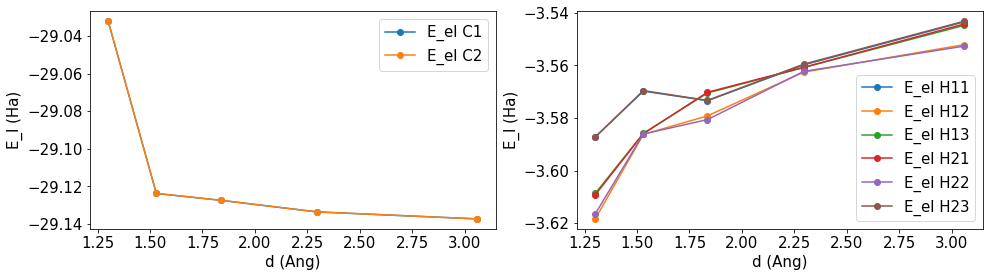

In [30]:
plt.rcParams['figure.figsize'] = [16,4]
plt.rcParams['font.size'] = 15
fig, ax = plt.subplots(1,2)

for k in e_vs_d.keys():
    if 'C' in k:
        ax[0].plot(dist*1.53, e_vs_d[k], '-o', label=f'E_el {k}')
    else:
        ax[1].plot(dist*1.53, e_vs_d[k], '-o', label=f'E_el {k}')
        
for i in range(2):
    ax[i].legend()
    ax[i].set_xlabel('d (Ang)')
    ax[i].set_ylabel('E_I (Ha)')
#ax[1].legend()

In [ ]:
-2.58531692 A.U. lambda = 6/14; d =d_eq*0.85

-2.62564887 A.U. lambda = 6/14; d =d_eq*1.5

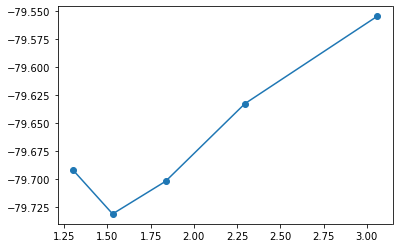

In [19]:
total_energy_from_atomic = []
for k in corrected_atomic_energies.keys():
    summed_energy = 0
    for k2 in corrected_atomic_energies[k].keys():
        summed_energy += corrected_atomic_energies[k][k2]
    total_energy_from_atomic.append(summed_energy)
plt.plot(dist*1.53, total_energy_from_atomic, '-o')

In [20]:
corrected_atomic_energies

{'d_0.85': {'C1': -29.03220895367274,
  'C2': -29.032134061860408,
  'H11': -3.587274895113092,
  'H12': -3.6184022607166293,
  'H13': -3.608714913411576,
  'H21': -3.6092430180617576,
  'H22': -3.6165174876162376,
  'H23': -3.5872041257367187},
 'd_1.0': {'C1': -29.123754713636377,
  'C2': -29.123703192760303,
  'H11': -3.569759263399324,
  'H12': -3.5862355582659013,
  'H13': -3.5858181937447697,
  'H21': -3.5859749090987516,
  'H22': -3.586086774335261,
  'H23': -3.569568201925475},
 'd_1.2': {'C1': -29.12736732140842,
  'C2': -29.12735411866847,
  'H11': -3.5734071675348518,
  'H12': -3.5791713069158932,
  'H13': -3.5704836880422106,
  'H21': -3.5701937861149617,
  'H22': -3.580600838553756,
  'H23': -3.573290760561943},
 'd_1.5': {'C1': -29.133548300179122,
  'C2': -29.133550689713754,
  'H11': -3.559772916167244,
  'H12': -3.5625403013386268,
  'H13': -3.5607731081647063,
  'H21': -3.5607123553213986,
  'H22': -3.562247270349596,
  'H23': -3.559497110673616},
 'd_2.0': {'C1': -29

In [45]:
total_energy_molecule = 0
for k in e_tot_atoms.keys():
    total_energy_molecule += np.array(e_tot_atoms[k])

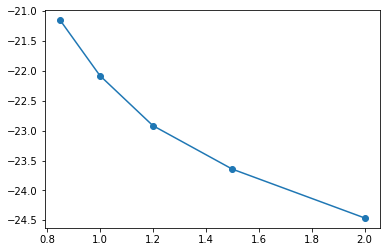

In [46]:
plt.plot(dist, total_energy_molecule, '-o')

In [47]:
energy_d08 = [-1.17019873, -2.58531692, -4.34034164, -8.49083416, -14.91582511]

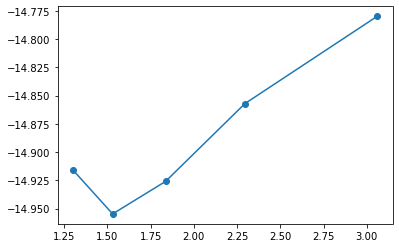

In [48]:
d = np.array([0.85, 1.0, 1.2, 1.5, 2])*1.53
energy_pw = np.array([-14.91582511, -14.95472337, -14.92595936, -14.85706745, -14.77976953])

plt.plot(d, energy_pw, '-o')

#### Energy in Angstrom

In [ ]:
from ase.units import Bohr
nuc_Ang = nuclei10.copy()
nuc_Ang[:, 1:4] = nuc_Ang[:, 1:4]*Bohr
gpt_Ang = [g*Bohr for g in gpts]
hmatrix_Ang = hmatrix*Bohr
alchpots_ang = get_alchpot(cubes08, ueg, nuc_Ang, gpt_Ang, hmatrix_Ang, intg_method = 'sum')
alchpots_ang_ordered = order_alchpots(alchpots_ang)

In [ ]:
lambdas = np.array([0, 3,6,8,11,14])/14
(np.trapz(alchpots_ang_ordered['H11'], lambdas))

# PYSCF

In [51]:
from pyscf import gto, scf, mp, cc, dft
import numpy as np
import ase

from matplotlib import pyplot as plt

import pandas as pd
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm

### Get Ethane 

In [52]:
amons_dict = uqm.load_obj('/home/misa/datasets/amons_qm9_11k/unique_amons_dict')

In [53]:
ethane_text = amons_dict['CC']

In [54]:
coords = []
elements = ''
for line in ethane_text[2:]:
    el, x, y, z = line.split()
    coords.append([float(x),float(y),float(z)])
    elements += el
    
ethane = ase.Atoms(elements, coords)
coords = ethane.get_positions()
vec_CC = coords[1] - coords[0]
d_CC = np.linalg.norm(vec_CC)

stretch_percentage = np.array([0.85, 1.0, 1.2, 1.5, 2])
shift_vecs = []
for sp in stretch_percentage:
    shift_vec = vec_CC*sp - vec_CC
    shift_vecs.append(shift_vec)

### Calculate energies

In [55]:
e_pbe = []

for sv in shift_vecs:
    new_coords = ethane.get_positions().copy()
    new_coords[1] += sv
    new_coords[5] += sv
    new_coords[6] += sv
    new_coords[7] += sv
    
    atom = []
    for a, c in zip(elements, new_coords):
        atom.append([a, (c)])
    
    
    new_coords = ethane.get_positions().copy()
    new_coords[1] += sv
    new_coords[5] += sv
    new_coords[6] += sv
    new_coords[7] += sv

    atom = []
    for a, c in zip(elements, new_coords):
        atom.append([a, c])

    mol = gto.Mole()
    mol.verbose = 0
    #mol.output = 'H2_{}.log'.format(d)
    mol.atom = atom
    mol.basis = 'def2tzvp'
    mol.build()

    # PBE
    mdft = dft.RKS(mol)
    mdft.xc = 'pbe'
    e_pbe.append(mdft.kernel())

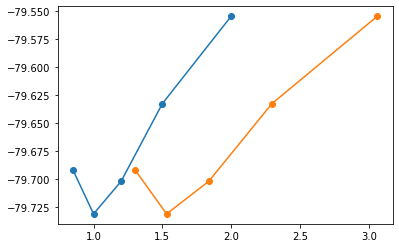

In [61]:
plt.plot(stretch_percentage, e_pbe, '-o')
deq = np.linalg.norm(ethane.get_positions()[0]-ethane.get_positions()[1])
plt.plot(stretch_percentage*deq, e_pbe, '-o')

In [69]:
e_pbe

[-79.69169971618916,
 -79.73090080716617,
 -79.70186898780051,
 -79.63264205190806,
 -79.55480003172102]